## testing for pyarmfinder

In [123]:
import sys,os,subprocess,glob
import pandas as pd
pd.set_option('display.max_columns', 14)
pd.set_option('display.width', 200)
import numpy as np
import pylab as plt
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO
import urllib.request
sys.path.append('../')
from pyamrfinder import tools, app
datadir = '../pyamrfinder/data/'
dbdir = '../pyamrfinder/db/'

In [2]:
def fetch_sequence_db(name='card'):
    """get sequences"""
    
    path = datadir
    if name == 'card':
        url = 'https://github.com/tseemann/abricate/raw/master/db/card/sequences'
    elif name == 'resfinder':
        url = 'https://raw.githubusercontent.com/tseemann/abricate/master/db/resfinder/sequences'
    filename = os.path.join(path,"%s.fa" %name)
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
    return

fetch_sequence_db('resfinder')

In [ ]:
fname='/local/abricate/db/card/sequences'
f=open(fname,'r')
for i in f.readlines():

sp=SeqIO.parse(handle=f,format='fasta')
seqs=[]
print (seqs)

In [48]:
def make_blast_database(filenames):
    """Make blast dbs of multiple input files"""

    rec=[]
    for n in filenames:
        seqs = list(SeqIO.parse(n,'fasta'))
        for s in seqs:
            s.id = n + '~' + s.id
        rec.extend(seqs)
    #ref = list(SeqIO.parse('genomes/ecoli_k12.fa','fasta'))
    #ref[0].id = 'ecoli_k12~1'
    #rec.extend(ref)
    SeqIO.write(rec, 'out.fasta', 'fasta')
    cmd = 'makeblastdb -dbtype nucl -in out.fasta'
    subprocess.check_output(cmd, shell=True)
    return

make_blast_database(['../test_files/RF15B.fa','../test_files/RF15A.fa'])

In [115]:
def run_blast(target, ref='card', ident=90, coverage=75):
    """blast card seqs"""

    path = os.path.join(dbdir,'%s.fa' %ref)
    dbseqs = list(SeqIO.parse(path,'fasta'))
    print ('blasting %s sequences' %len(dbseqs))
    bl = tools.blast_sequences(target, dbseqs, maxseqs=100, evalue=.1,
                               cmd='blastn', show_cmd=True)
    #print (bl[:5])
    bl['qlength'] = bl.sequence.str.len()
    bl['coverage'] = bl.length/bl.qlength*100
    bl = bl[bl.coverage>coverage]
    bl = bl[bl.pident>ident]
    bl['filename'] = bl.sseqid.apply(lambda x: x.split('~')[0],1)
    bl['id'] = bl.filename.apply(lambda x: os.path.basename(x),1)
    bl['contig'] = bl.sseqid.apply(lambda x: x.split('~')[1],1)
    bl['gene'] = bl['qseqid'].apply(lambda x: x.split('~~~')[1],1)
    #print (bl)
    cols = ['qseqid','pident','sstart','send','coverage','contig','gene','id','filename']
    bl = bl[cols]
    return bl

bl = run_blast('out.fasta', 'resfinder')

blasting 3077 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db out.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2


In [116]:
bl[-6:]

,qseqid,pident,sstart,send,coverage,contig,gene,id,filename
396,resfinder~~~dfrA1_9~~~AJ238350~~~Trimethoprim,99.578,2680,3153,100.0,NODE_105_length_16198_cov_135.908,dfrA1_9,RF16A.fa,../test_files/RF16A.fa
397,resfinder~~~dfrA1_9~~~AJ238350~~~Trimethoprim,99.578,5615,6088,100.0,NODE_26_length_38011_cov_86.3981,dfrA1_9,RF15A.fa,../test_files/RF15A.fa
401,resfinder~~~mdf(A)_1~~~Y08743~~~,98.459,8684,7452,100.0,NODE_55_length_26978_cov_47.0204,mdf(A)_1,RF16A.fa,../test_files/RF16A.fa
503,resfinder~~~tet(B)_1~~~AP000342~~~Doxycycline;...,99.917,13599,14804,100.0,NODE_105_length_16198_cov_135.908,tet(B)_1,RF16A.fa,../test_files/RF16A.fa
504,resfinder~~~tet(B)_2~~~AF326777~~~Doxycycline;...,100.000,13599,14804,100.0,NODE_105_length_16198_cov_135.908,tet(B)_2,RF16A.fa,../test_files/RF16A.fa
505,resfinder~~~tet(B)_3~~~AJ277653~~~Doxycycline;...,99.585,13599,14804,100.0,NODE_105_length_16198_cov_135.908,tet(B)_3,RF16A.fa,../test_files/RF16A.fa


In [121]:
def find_gene_hits(res, gene, filename, db='card'):
    """Get blast hit results"""

    path = os.path.join(dbdir,'%s.fa' %db)
    #dbseqs = SeqIO.to_dict(SeqIO.parse(path,'fasta'))
    dbseqs = tools.fasta_to_dataframe(path)
    dbseqs['gene'] = dbseqs.description.apply(lambda x: x.split('~~~')[1],1)
    #print (dbseqs)
    x = res[res.gene==gene]
   
    found=[]
    contigs = []
    for i,r in x.iterrows():
        name = r.id
        print (name)
        #if name not in isolates: continue
        seqs = SeqIO.to_dict(SeqIO.parse(r.filename,'fasta'))
        node = r.contig
        if r.sstart<r.send:
            s = seqs[node].seq[r.sstart:r.send]
        else:
            s = seqs[node].seq[r.send:r.sstart].reverse_complement()

        s = SeqRecord(id=name,seq=s)
        found.append(s)
        print (name, r.gene, r['coverage'], r['pident'], len(s), node)
        #add card seq
        contigs.append(seqs[node])

    row = dbseqs[dbseqs.gene==gene].iloc[0]
    print (row)
    found.append(SeqRecord(id=row['name'],seq=Seq(row.sequence)))
    seqfile = 'temp.fa'
    SeqIO.write(found, seqfile,'fasta')
    SeqIO.write(contigs,'contigs.fa','fasta')
    #maaft_alignment(seqfile)
    aln = tools.clustal_alignment(seqfile)
    print (aln)
    return


In [122]:
find_gene_hits(bl, 'dfrA1_9', '../test_files/RF15B.fa', 'resfinder')

NameError: name 'dbdir' is not defined

In [120]:
def pivot_blast_results(bl):
    x = bl.drop_duplicates(['sstart'])
    m = pd.pivot_table(x, index='id', columns='gene', values='pident')#, aggfunc=np.size)   
    #m = m[m.columns[m.loc['ecoli_k12'].isnull()]]   
    #m = m.drop('ecoli_k12')
    return m

m = pivot_blast_results(bl)
m

gene,aac(3)-IV_1,aadA11_2,aadA23_1,aadA24_1,ant(3'')-Ia_1,aph(3'')-Ib_1,aph(3'')-Ib_2,...,aph(6)-Id_4,blaCTX-M-101_1,blaCTX-M-211_1,dfrA1_1,dfrA1_17,mdf(A)_1,tet(B)_1
id,,,,,,,,,,,,,,,
RF15A.fa,NaN,92.785,97.28,93.059,99.377,99.627,100.0,...,99.88,NaN,NaN,99.789,99.577,NaN,NaN
RF15B.fa,100.0,92.785,97.28,93.059,99.377,99.627,100.0,...,99.88,NaN,NaN,99.789,99.577,NaN,NaN
RF16A.fa,NaN,92.785,97.28,93.059,99.377,NaN,NaN,...,NaN,99.772,99.77,99.789,99.577,98.459,99.917


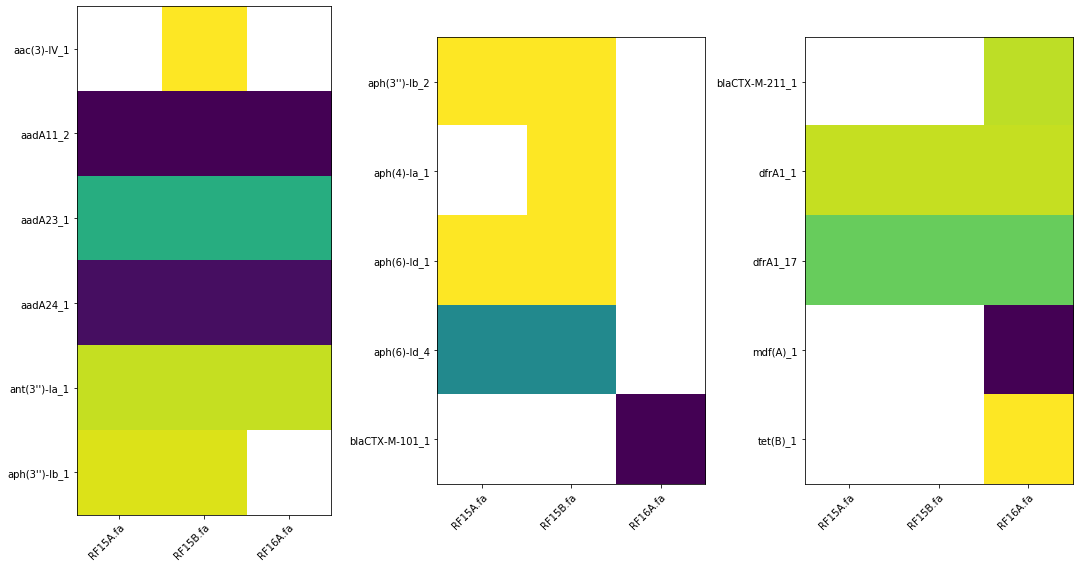

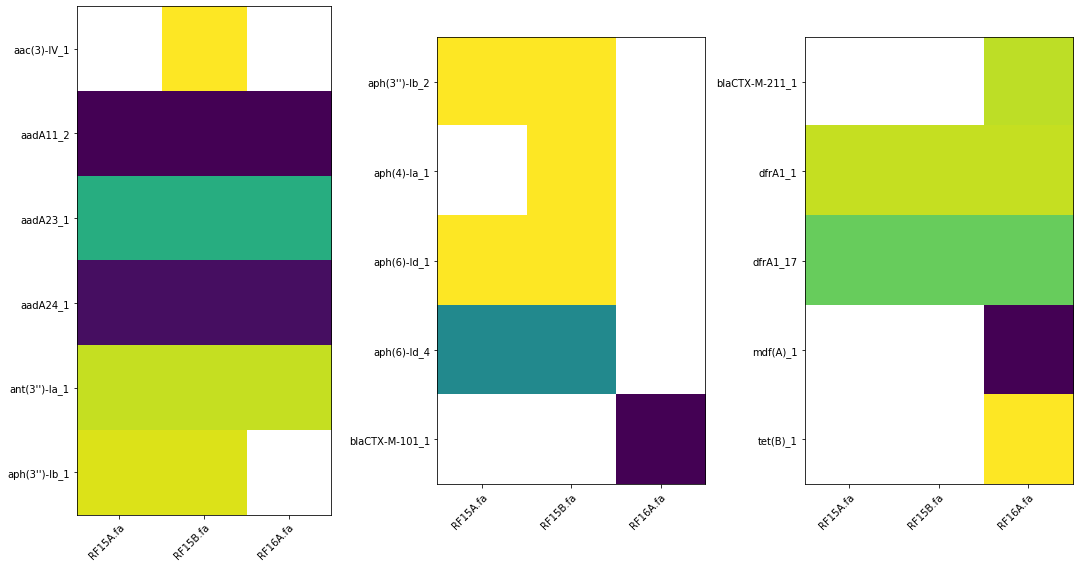

In [141]:
def merge_info(x):
    m=info[['id','stage']]
    x=m.merge(x,right_index=True,left_on='id')
    x=x.set_index(['stage','id'])
    return x

def plot_heatmap(m, fig=None):

    l=3    
    f,ax=plt.subplots(1,l,figsize=(15,8))
    axs=ax.flat
    chunks = np.array_split(m,l)    
    i=0
    for df in chunks:
        #df=m[cols]
        ax=axs[i]
        im = ax.imshow(df)
        ax.set_xticks(np.arange(len(df.T)))
        ax.set_yticks(np.arange(len(df)))
        ax.set_xticklabels(df.columns)
        ax.set_yticklabels(df.index)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
        i+=1
    plt.tight_layout()
    return f

plot_heatmap(m.T)

blasting 3077 sequences
blastn -out tempseq_blast.txt -outfmt "6 qseqid sseqid qseq sseq pident qcovs length mismatch gapopen qstart qend sstart send evalue bitscore stitle" -query tempseq.fa -db out.fasta -evalue 0.1 -max_target_seqs 100 -num_threads 2
gene      aac(3)-IV_1  aadA11_2  aadA23_1  aadA24_1  ant(3'')-Ia_1  aph(3'')-Ib_1  aph(3'')-Ib_2  ...  aph(6)-Id_4  blaCTX-M-101_1  blaCTX-M-211_1  dfrA1_1  dfrA1_17  mdf(A)_1  tet(B)_1
id                                                                                                ...                                                                                    
RF15A.fa          NaN       1.0       1.0       1.0            1.0            1.0            1.0  ...          1.0             NaN             NaN      1.0       1.0       NaN       NaN
RF15B.fa          1.0       1.0       1.0       1.0            1.0            1.0            1.0  ...          1.0             NaN             NaN      1.0       1.0       NaN       NaN
RF

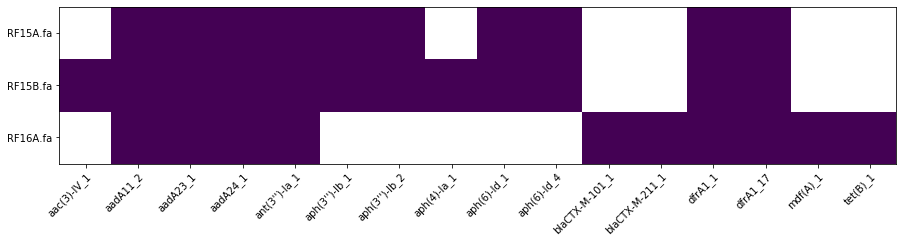

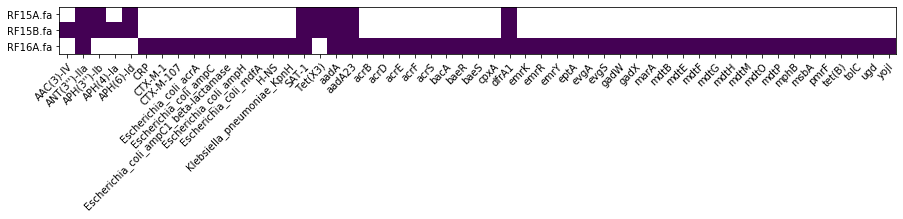

In [118]:
# run in sequence

def run(filenames, db='card'):
    """Run pipeline"""
    
    fetch_sequence_db(db)
    make_blast_database(filenames)
    bl = run_blast('out.fasta', db)
    #find_gene_hits(bl, 'dfrA1_9', '../test_files/RF15B.fa', db)
    bl.to_csv('%s_results.csv' %db)
    m = pivot_blast_results(bl)
    print (m)
    plot_heatmap(m)
    m.to_csv('%s_matrix.csv' %db)
    return

inpath = '../test_files/'
filenames = glob.glob(os.path.join(inpath,'*.fa*'))
run(filenames, db='resfinder')
run(filenames, db='card')